<a href="https://colab.research.google.com/github/DrAlexSanz/Image-SR/blob/master/BLUR_Mid_Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook implements the deeper UNET architecture. It is applied as a deblurring autoencoder as an intermediate way to work on the "deblurrer" and the image super-resolution.

It works on a 300x300 patch of images taken from the flickr 8k dataset. I could have done it for bigger images but I can only run this on colab because my computer is what it is. On the other hand, 300x300 is a reasonable size, it's small enough to run in a reasonable time but it's big enough for a realistic problem. It's one order of magnitude bigger in each dimension than the mnist equivalent (what I called small unet). It also has the advantage that the dataset fits in memory and I don't have to develop a custom Image data generator. This is the next thing I will do.

First import things that I will need and a bit more that I may need later.

In [1]:
import numpy as np
import os, shutil
from keras import backend as K
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Add, BatchNormalization, Concatenate, Conv2DTranspose, ZeroPadding2D, Cropping2D
from keras.models import Model, load_model
from keras.utils import plot_model
from keras.optimizers import Adam, Adadelta, Adagrad
from keras.callbacks import History, ModelCheckpoint
import matplotlib.pyplot as plt
import glob
import cv2
from PIL import Image, ImageFilter
from scipy.ndimage.filters import gaussian_filter

K.set_image_data_format("channels_last")

Using TensorFlow backend.


Get the auxiliary functions that I developed from my colab.

In [2]:
!wget https://raw.githubusercontent.com/DrAlexSanz/Image-SR/master/big_UNET.py
from big_UNET import *

--2019-10-09 05:17:11--  https://raw.githubusercontent.com/DrAlexSanz/Image-SR/master/big_UNET.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6448 (6.3K) [text/plain]
Saving to: ‘big_UNET.py’

big_UNET.py         100%[===================>]   6.30K  --.-KB/s    in 0s      

2019-10-09 05:17:11 (93.1 MB/s) - ‘big_UNET.py’ saved [6448/6448]



Mount my google drive to access my dataset.

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


As I said, the function loads the dataset into a numpy vector (tensor). It takes the picture, crops a 300x300 patch from it and saves it in the X array. The patch is always the top left corner, as explained inside, for simplicity. Could be randomly taken and I will probably implement this in the Data Generator. In any case, the patch is big enough to capture a reasonable proportion of the image. Not a lot of information is lost. This function is not the fastest one, but I only run it the first time and then I save the vector. Loading the array is very fast. Comment or uncomment the lines below as needed.

In [0]:
path_flickr = "/content/drive/My Drive/flickr"

In [0]:
X = load_imgs_to_array(path_flickr)

# np.save("./pic.npy", x_list) For future use if it gets to that.

In [0]:
# np.save("/content/drive/My Drive/Image-SR/pic.npy", X)

In [0]:
X = np.load("/content/drive/My Drive/Image-SR/pic.npy") # Very fast once it is created

Make sure I loaded what I wanted to load.

In [6]:
np.array(X).shape

(600, 300, 300, 3)

Make the train, test and validation datasets. The dataset is already random as far as I can see looking at the pictures. I take the first 400 pictures as train set, then 100 as a test set and the last 100 as a validation set, to predict.

Some people may argue that 400 pictures are not too many. I could do more, of course, but then it takes longer to run. As I said, I wanted to find a compromise between a realistic training set and a fast one. I don't get anything from having the script run for two weeks.

In [0]:
X_train = X[:400, :, :] # Remember, this takes from 0 to 799, 800 is taken in the next one
X_val = X[400:500, :, :] # Math notation = [a, b)
X_test = X[500:600, :, :]

Make sure I split the data properly.

In [8]:
X_train.shape

(400, 300, 300, 3)

Thake the ground truths and add the noise to create the inputs. I think 0.15 as a factor is reasonable. It's random gaussian noise (not blurr) that is added to the picture. After normalizing and adding the noise I clip it at 1 just for a better convergence. It should converge also If I skip this step but this will most likely make it faster.

At a 0.5 noise factor the problem is much harder. The epochs, learing rate and the model should be refined.

In [0]:
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")
X_val = X_val.astype("float32")

X_train = X_train/255
X_test = X_test/255
X_val = X_val/255

# Free memory
del X

Loading the images as a vector is easier. It's important to apply the blur while they are images instead of np arrays. Otherwise it does a convolution on all the channels at the same time, not a 2D filter for each channel.

In [0]:
X_list = load_imgs_blurred(path_flickr)

In [0]:
np.save("/content/drive/My Drive/Image-SR/blur.npy", X_list)

In [0]:
X_list = np.load("/content/drive/My Drive/Image-SR/blur.npy")

In [0]:
X_blur_train = X_list[:400, :, :] # Remember, this takes from 0 to 799, 800 is taken in the next one
X_blur_val = X_list[400:500, :, :] # Math notation = [a, b)
X_blur_test = X_list[500:600, :, :]

X_blur_train = X_blur_train.astype("float32")
X_blur_val = X_blur_val.astype("float32")
X_blur_test = X_blur_test.astype("float32")

X_blur_train = X_blur_train/255
X_blur_val = X_blur_val/255
X_blur_test = X_blur_test/255

del X_list

I will show a few images to check that everything works.

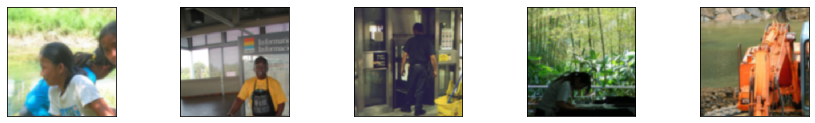

In [12]:
n = 5
plot_some_pics(n, X_blur_test)


I define the magnitudes of the different tensor dimensions and call the definition function. Plot the summary.

In the definition, the BatchNorm layers are commented out. I found out that they don't result on a significant improvement on convergence. Therefore leaving them active won't be too advantageous.

In [13]:
width = X_train.shape[1]
height = X_train.shape[2]
n_channels = X_train.shape[3]

big_u = Big_UNET(width, height, n_channels)
big_u.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
C1 (Conv2D)                     (None, 300, 300, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
C2 (Conv2D)                     (None, 150, 150, 128 73856       C1[0][0]                         
__________________________________________________________________________________________________
C3 (Conv2D)                     (None, 75, 75, 256)  295168      C2[0][0]                         
___________________________________________________________________________________________

Plot the model to see that my connections are correct. They seem to be ok.

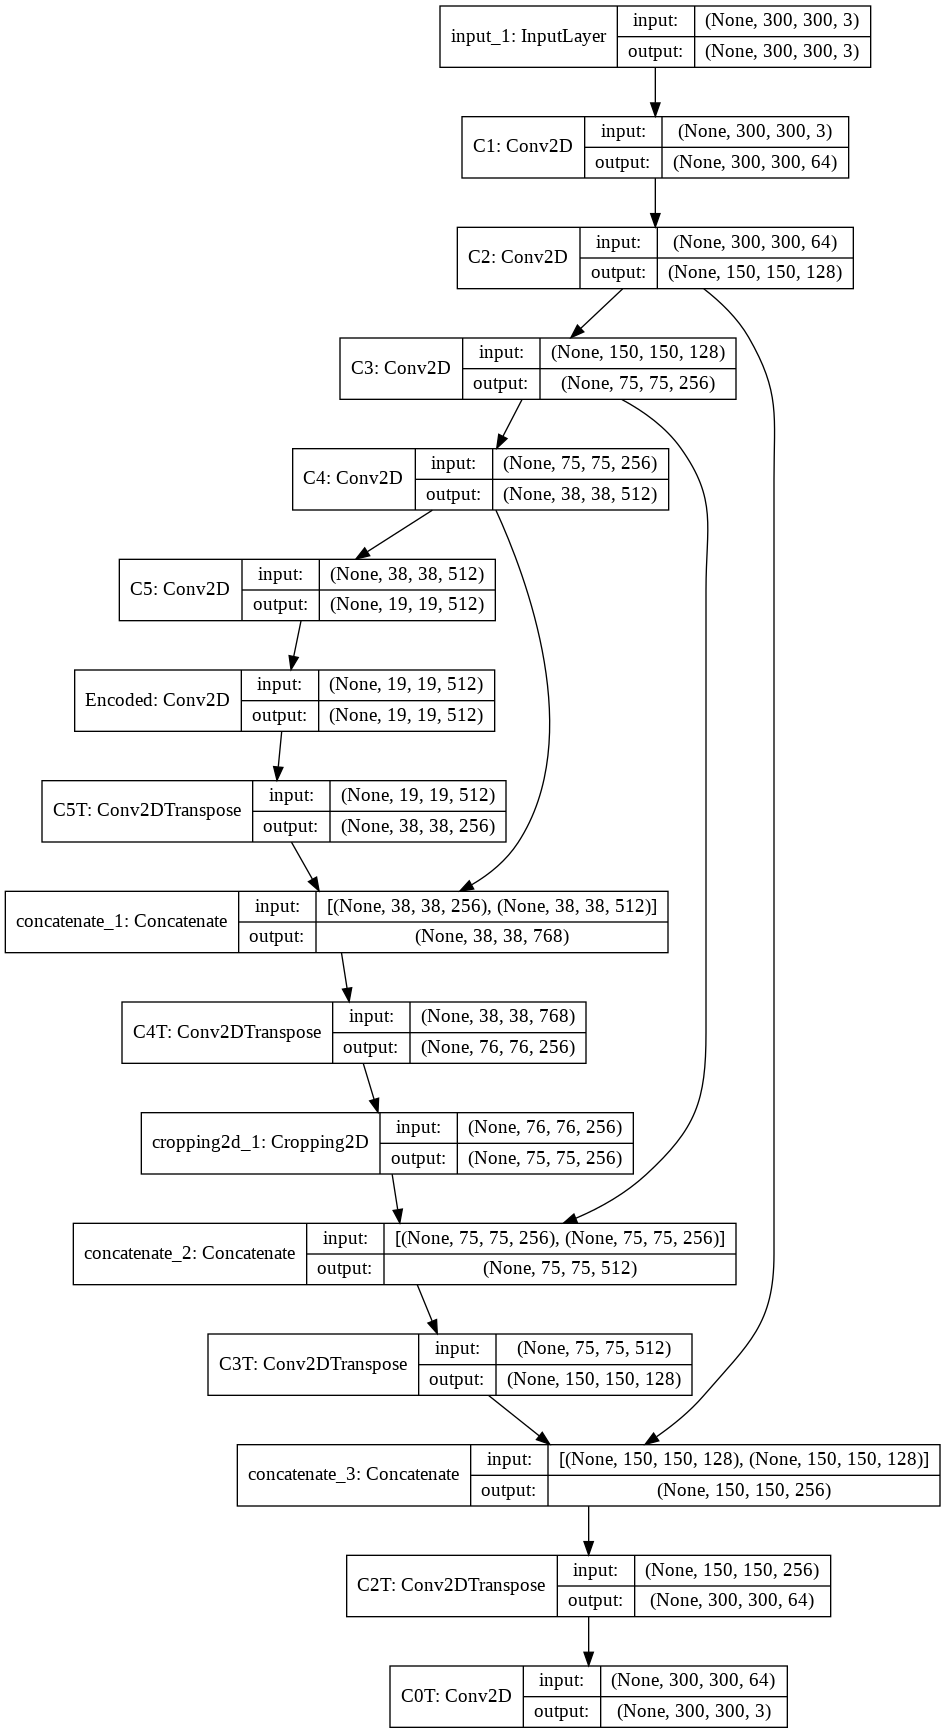

In [14]:
plot_model(big_u, to_file = "Big_Unet.png",show_shapes = True)

Train the model. Add the history and checkpoint callbacks. I don't want to lose 1 h of training if the session runs out. The history will be used later to plot the training process.

As optimizer use Adadelta. For some reason Adam and Adagrad are not as efficient. They tend to stagnate for several iterations. The default parameters work ok with a 0.05 learning rate.

I set the number of iterations to 200 or 300. You need about 200 to start seeing something reasonable in the predicted images. At the beginning they are mostly grey.

As a loss function MSE is better in this case. Binary Crossentropy is ok too but there is a drawback, the function is not symmetric. Looking at the definition:

$L = -\sum p\cdot log(p)$

The log function is not symmetric, which translates into a general assymetry of the , so the side in which I iterate will make a difference. Besides, since I want to rebuild the picture, MSE or even MAE seem more correct from the conceptual point of view. Ideally, all the pixels would be the same after the training process.

In [15]:
opti = Adadelta(lr = 0.05)
hist = History()
path_save = "/content/drive/My Drive/Image-SR/blur_epoch_{epoch:04d}.h5" #the current one
checkpointer = ModelCheckpoint(path_save, period = 25, save_best_only = True, save_weights_only = True)
big_u.compile(optimizer = opti, loss = "mean_squared_error")
num_it = 300

In [0]:
# big_u.load_weights("/content/drive/My Drive/Image-SR/big_u_0200.h5")

Now I train the model.

In [16]:
big_u.fit(X_blur_train, X_train, epochs = num_it, batch_size = 16, shuffle = True, validation_data = (X_blur_test, X_test), callbacks = [hist, checkpointer])

Train on 400 samples, validate on 100 samples
Epoch 1/300
400/400 [==============================] - 55s 137ms/step - loss: 0.0848 - val_loss: 0.0808
Epoch 2/300
400/400 [==============================] - 38s 96ms/step - loss: 0.0826 - val_loss: 0.0788
Epoch 3/300
400/400 [==============================] - 39s 97ms/step - loss: 0.0805 - val_loss: 0.0769
Epoch 4/300
400/400 [==============================] - 39s 97ms/step - loss: 0.0784 - val_loss: 0.0749
Epoch 5/300
400/400 [==============================] - 39s 97ms/step - loss: 0.0762 - val_loss: 0.0727
Epoch 6/300
400/400 [==============================] - 39s 97ms/step - loss: 0.0738 - val_loss: 0.0704
Epoch 7/300
400/400 [==============================] - 39s 98ms/step - loss: 0.0712 - val_loss: 0.0677
Epoch 8/300
400/400 [==============================] - 39s 98ms/step - loss: 0.0682 - val_loss: 0.0647
Epoch 9/300
400/400 [==============================] - 39s 98ms/step - loss: 0.0648 - val_loss: 0.0612
Epoch 10/300
400/400 [====

Print the keys of the history callback to see where my losses are.

In [17]:
print(hist.history.keys())

dict_keys(['val_loss', 'loss'])


Plot the training and test history.

## Comment on the losses values

The train loss starts higher than the test loss, although not by a great margin. Then they cross and finally the training loss is a bit lower than the test loss.

This looks weird at first. For starters, this can be caused by dropout, by BatchNorm or some other regularization techniques. This is not the case. The last cause of this can be the mini batches. The parameters of the network are updated after every mini batch. Therefore for every mini batch my network is slightly better than before and the loss, which is averaged for all the mini batches in an epoch, is slightly better than the test loss.

Then, if the machine is constantly improving and does not overfit, the gap between the network's average performance in an epoch and its performance at the end of an epoch is translated into the gap between training and validation scores - in favor of the validation scores.

Considering minor variations that result from the random process of sample generation (even if data is generated only once, but especially if it is generated anew for each epoch).

Therefore, I can confidently state that I'm not overfitting. I would if I had enough iterations and parameters to capture the whole dataset.

[Source](https://datascience.stackexchange.com/questions/32927/understanding-lstm-behaviour-validation-loss-smaller-than-training-loss-through)


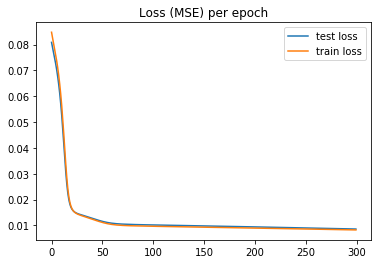

In [18]:
plt.figure();
plt.title("Loss (MSE) per epoch");
plt.plot(range(num_it), list(hist.history.values())[0], label = "test loss");
plt.plot(range(num_it), list(hist.history.values())[1], label = "train loss");
plt.legend();

In [0]:
X_decoded = big_u.predict(X_blur_val)

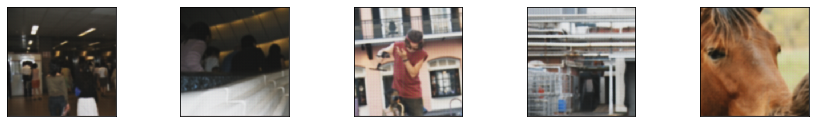

In [20]:
n = 5
plot_some_pics(n, X_decoded)